In [ ]:
import torch
import os

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


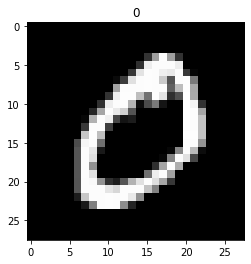

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[1], cmap='gray')
plt.title('%i' % train_data.targets[1])
plt.show()

In [ ]:
print(train_data.data.shape)

torch.Size([60000, 28, 28])


In [ ]:
train_data_new=torch.unsqueeze(train_data.data.clone(), dim=-1).repeat((1, 1, 1, 3))


In [ ]:
import numpy as np
prova=train_data_new.numpy().astype(np.uint8)
prova=torch.tensor(prova)

In [ ]:
prova.shape

torch.Size([60000, 28, 28, 3])

In [ ]:
train_data_new.shape

torch.Size([60000, 28, 28, 3])

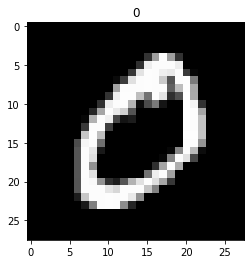

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_data_new[1])
plt.title('%i' % train_data.targets[1])
plt.show()

In [ ]:
image=train_data_new[1]
larghezza=5
biased_image= image.clone()
biased_image[:larghezza,:larghezza,2]=255


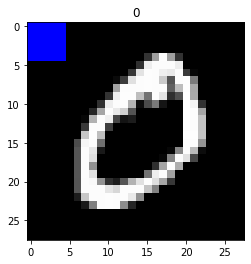

In [ ]:
plt.imshow(biased_image)
plt.title('%i' % train_data.targets[1])
plt.show()

In [ ]:
from PIL import Image

Image.fromarray(biased_image.numpy().astype(np.uint8)).save(
                    os.path.join("/content/data", f"{id}.png")
                )

In [ ]:
from torch.utils.data import DataLoader
train_data.data=prova
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=128, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=128, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fc75f81aeb0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fc75f81a070>}

In [ ]:
for i in loaders['train']:
  print(i[0])
  break

ValueError: ignored

In [ ]:
import torch.nn as nn


class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 16, (3, 3), (1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)),
            nn.Conv2d(16, 32, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)),
            nn.Flatten()
        )

        self.linear = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(256, self.num_classes)
        )

    def get_grad_cam_target_layer(self):
        return self.backbone[-3]

    def forward(self, x):
        features = self.backbone(x)
        logits = self.linear(features)

        return logits

In [ ]:
cnn = SmallCNN(2)
print(cnn)

SmallCNN(
  (backbone): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Flatten(start_dim=1, end_dim=-1)
  )
  (linear): Sequential(
    (0): Linear(in_features=512, out_features=

In [ ]:
import os
import torchvision

from tqdm import tqdm
from torch import Tensor


class AverageMeter(object):
    """Computes and stores the average and current value
    Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class Logger:
    def __init__(self, path: str, config: str) -> None:
        self.path = path
        if not config is None:
            with open(os.path.join(self.path, "log.txt"), "a") as f:
                f.write(config + "\n")

    def info(self, msg: str, print_msg: bool = False) -> None:
        if print_msg:
            print(msg)
        with open(os.path.join(self.path, "log.txt"), "a") as f:
            f.write(msg + "\n")

def calculate_accuracy(labels: torch.tensor, outputs: torch.tensor):
    equals = labels.eq(outputs)
    return torch.sum(equals).item() / len(labels)

In [ ]:
import torch.nn.functional as F
import torch.optim as optim

class TrainBaseERM:
    def __init__(self):
      
      self.loss_function=nn.CrossEntropyLoss()
      self.model=SmallCNN(2)
      self.logger = Logger("/content", None)
      self.optimizer=optim.SGD(
                self.model.parameters(),
                lr=0.01,
                momentum=0.9,
                weight_decay=1e-4
            )

    def run_an_epoch(self, data_loader, epoch, mode="train", device='cpu'):
        if mode == "train":
            self.model.train()
        else:
            self.model.eval()

        losses = AverageMeter()
        accuracies = AverageMeter()
        with torch.set_grad_enabled(mode == "train"):
            progress_bar = tqdm(data_loader)
            self.logger.info(
                f"{mode} epoch: {epoch}"
            )
            for data in progress_bar:
                progress_bar.set_description(f'{mode} epoch {epoch}')
                inputs, targets = data[0], data[2]
                inputs, targets = inputs.to(
                    device), targets.to(device)
                outputs = self.model(inputs)
                loss = self.loss_function(outputs, targets)
                losses.update(loss.item(), inputs.size(0))
                output_probabilities = F.softmax(outputs, dim=1)
                probabilities, predictions = output_probabilities.data.max(1)
                accuracies.update(calculate_accuracy(targets, predictions), 1)
                if mode == "train":
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                progress_bar.set_postfix(
                    {
                        "loss": losses.avg,
                        "accuracy": accuracies.avg,
                    }
                )
            self.logger.info(
                f"loss: {losses.avg}"
            )
            self.logger.info(
                f"accuracy: {accuracies.avg}"
            )
        return accuracies.avg


In [ ]:
train= TrainBaseERM()

train.run_an_epoch(loaders['train'],0)

train epoch 0: 100%|██████████| 469/469 [01:07<00:00,  6.99it/s, loss=0.709, accuracy=0.503]


0.5030261638237384

In [ ]:
train.run_an_epoch(loaders['train'],1)

train epoch 1: 100%|██████████| 469/469 [01:06<00:00,  7.05it/s, loss=0.704, accuracy=0.503]


0.5034481609808102

In [ ]:
train.run_an_epoch(loaders['train'],2)

train epoch 2: 100%|██████████| 469/469 [01:04<00:00,  7.27it/s, loss=0.703, accuracy=0.508]


0.507940209665956

In [ ]:
train.run_an_epoch(loaders['train'],3)

train epoch 3: 100%|██████████| 469/469 [01:04<00:00,  7.27it/s, loss=0.703, accuracy=0.511]


0.5107664800995024

In [ ]:
progress_bar = tqdm(loaders['train'])
for data in progress_bar:
  print(data[1])
  break

  0%|          | 0/469 [00:00<?, ?it/s]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


  0%|          | 0/469 [00:00<?, ?it/s]


In [ ]:
from torchvision.datasets import MNIST
from PIL import Image
import numpy as np
from glob import glob

class BiasedMNIST(MNIST):
  def __init__(
      self,
      new_to_old_label_mapping={0: [0, 1, 2, 3, 4], 1: [5, 6, 7, 8, 9]},
      bias_conflicting_data_ratio=0.1,
      biased=False,
      **kwargs,
  ) -> None:
        super().__init__(**kwargs)
        self.train = kwargs["train"]
        self.return_masked = False
        if kwargs["train"]:
            self.split = "train"
        else:
            self.split = "test"

        #to do if su argomento biased
        self.img_data_dir = os.path.join(
            kwargs["root"],
            "MNISTRGB",self.split)
        
        print(self.img_data_dir)
        self.data_rgb=[]
        self.data_rgb_paths=[]
        #modifico label: [0,1,2,3,4] -> 0  [5,6,7,8,9] -> 1
        self.modify_labels()
        if not (os.path.isdir(self.img_data_dir) and len(os.listdir(self.img_data_dir)) > 0):
            print(
                f"\n\nstart creating and saving {self.split} dataset of BiasedMnist\n\n"
            )
            os.makedirs(self.img_data_dir, exist_ok=True)
            
            #data_rgb conterrà le immagini di mnist ma in rgb
            self.data_rgb= self.from_BlackWhite_to_RGB()
            self.data_rgb_paths=[]

            #bisogna salvare le immagini rgb per prenderle poi in un secondo momento
            for id, (data, target) in enumerate(zip(self.data_rgb, self.targets)):
                Image.fromarray(data.numpy().astype(np.uint8)).save(
                    os.path.join(self.img_data_dir, f"{id}.png")
                )
                self.data_rgb_paths.append(os.path.join(self.img_data_dir, f"{id}.png"))
        else:
           image_file_paths = glob(
                os.path.join(self.img_data_dir, "*")
            )
           
           for image_path in image_file_paths:
              temp = Image.open(image_path)
              keep = temp.copy()
              
              self.data_rgb.append(keep)
              temp.close()
              
           
           
           self.data_rgb_paths += image_file_paths

        #print(torch.Tensor(self.data_rgb))
            
    
  def modify_labels(self):
        #group1=[0,1,2,3,4]
        #group2=[5,6,7,8,9]
        #for i, target in enumerate(self.targets):
         # if target in group1:
          #  self.targets[i]=0
          #else:
           # self.targets[i]=1
      self.targets = torch.tensor(np.where(self.targets<5,0,1))
  def from_BlackWhite_to_RGB(self):
       data_to_transform = self.data.clone()
       data_to_transform = torch.unsqueeze(data_to_transform, dim=-1).repeat((1, 1, 1, 3))
       return data_to_transform
  
  def __len__(self):
        return len(self.data_rgb_paths)

  def __getitem__(self, index: int):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, img_file_path, target) where target is index of the target class.
        """
        img, img_file_path, target = self.data_rgb[index], self.data_rgb_paths[index], self.targets[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, img_file_path, target


In [ ]:
train_data_RGB = BiasedMNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)

data/MNISTRGB/train


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f9054fb3dc0>
Traceback (most recent call last):
  File "/usr/lib/python3.8/weakref.py", line 345, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


In [ ]:
test_data_RGB = BiasedMNIST(
    root = 'data',
    train = False,                         
    transform = ToTensor(), 
    download = True,            
)

data/MNISTRGB/test


start creating and saving test dataset of BiasedMnist




In [ ]:
train_data_RGB.targets

tensor([1, 0, 0,  ..., 1, 1, 1])

In [ ]:
from torch.utils.data import DataLoader

loaders = {
    'train' : torch.utils.data.DataLoader(train_data_RGB, 
                                          batch_size=128, 
                                          shuffle=True, 
                                          num_workers=1)
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f8fa58a3e80>}

In [ ]:
for i in loaders['train']:
  print(i)
  break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

In [ ]:
progress_bar = tqdm( loaders['train'])
for data in progress_bar:
  print(data[2])
  break

  0%|          | 0/469 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 0])


In [ ]:
!rm data/MNISTRGB -r

In [ ]:
import prova
prova.ciao()


Hepòòòo
